In [1]:
# --- IMPORTATIONS ---

import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import PartialDependenceDisplay

import lightgbm as lgb

In [2]:
# --- PATHS ---

MAIN_DIR = "black_box_model"
GRAPHS_DIR = os.path.join(MAIN_DIR, 'graphs')
MODEL_DIR = os.path.join(MAIN_DIR, 'model')
DATA_DIR = 'data'
os.makedirs(GRAPHS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# --- Loading the dataset ---

data_path = os.path.join(DATA_DIR, 'dataproject2025.csv')
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: 'dataproject2025.csv' not found at {data_path}.")


Dataset loaded successfully.
Shape of the dataset: (1086236, 39)


In [6]:
# --- SAME DATA CLEARNING (MAYBE JUST DOWNLOAD CLEANED DATA) ---

# Identify columns to exclude from features
columns_to_exclude = [c for c in ['target', 'Predictions', 'Predicted probabilities', 'Unnamed: 0'] if c in df.columns]
# Drop sensitive attribute(s)
columns_to_exclude += [c for c in df.columns if 'Pct_afro_american' in c]

# The 'target' column is our dependent variable (y)
y = df['target']

# The rest of the columns are potential features (X)
X = df.drop(columns=columns_to_exclude, errors='ignore')

# Preserve the identifier column for later export if present
id_series = df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else pd.Series(np.arange(len(df)), name='Unnamed: 0')

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Automatically identify numerical and categorical columns
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Found {len(numerical_features)} numerical features.")
print(f"Found {len(categorical_features)} categorical features.")

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Features (X) shape: (1086236, 34)
Target (y) shape: (1086236,)
Found 28 numerical features.
Found 6 categorical features.


# BUILDING AND TRAINING PIPELINE

In [ ]:
# Create a preprocessing pipeline for numerical features:
# 1. Impute missing values with the median
# 2. Scale features to a standard range
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a preprocessing pipeline for categorical features:
# 1. Impute missing values with a constant string 'missing'
# 2. One-hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False is often helpful for HistGradientBoostingClassifier
])

# Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# --- FULL MODEL PIPELINE ---

# Define the model using LightGBM with explicit l2 (MSE) objective
model = lgb.LGBMRegressor(objective='l2', n_estimators=200, random_state=42)

# Create the full pipeline by chaining the preprocessor and the model
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

print("--- Full Model Pipeline ---")
print(full_pipeline)


--- Full Model Pipeline ---
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issue_d', 'loan duration',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_open_to_buy', 'bc_util',
                                                   'delinq_2yrs', 'dti',
                                                   'fico_range_high',
                                                   'funded_amnt',
                             

In [ ]:
print("Training the model...")
# The pipeline handles imputation, scaling, and encoding automatically
train_weights = np.where(y_train.values == 1, 2.0, 1.0)
full_pipeline.fit(X_train, y_train, classifier__sample_weight=train_weights)
print("Model training complete.")

Training the model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 868988, number of used features: 148
[LightGBM] [Info] Start training from score 0.347784
Model training complete.


In [ ]:
# --- SAVING THE PIPELINE ---

joblib.dump(full_pipeline, 'model/grad_boost_pipeline.joblib')

['model/grad_boost_pipeline.joblib']

# PARTIAL DEPENDANCE PLOT

In [4]:
full_pipeline = joblib.load('black_box_model/model/grad_boost_pipeline.joblib')

Partial dependance plot

In [12]:
n_sample = 250 # how many instances to take into consideration (1 million is too long)

/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation

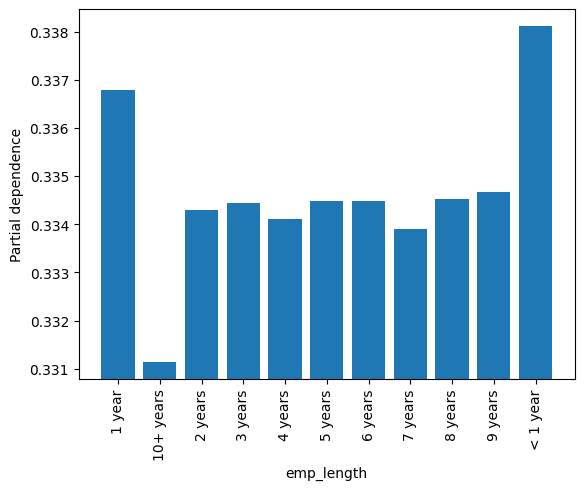

In [13]:
PartialDependenceDisplay.from_estimator(full_pipeline, # model pipeline
                                        X_train.sample(n_sample), # dataset
                                        features=['emp_length'], #
                                        categorical_features=['emp_length'])

In [14]:
numerical_features

['issue_d',
 'loan duration',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_2yrs',
 'dti',
 'fico_range_high',
 'funded_amnt',
 'inq_last_6mths',
 'int_rate',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'num_actv_bc_tl',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_accts',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'revol_util',
 'tax_liens',
 'zip_code']

/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/paul-philiplouis/anaconda3/envs/dynamic/lib/python3.12/site-packages/sklearn/utils/validation

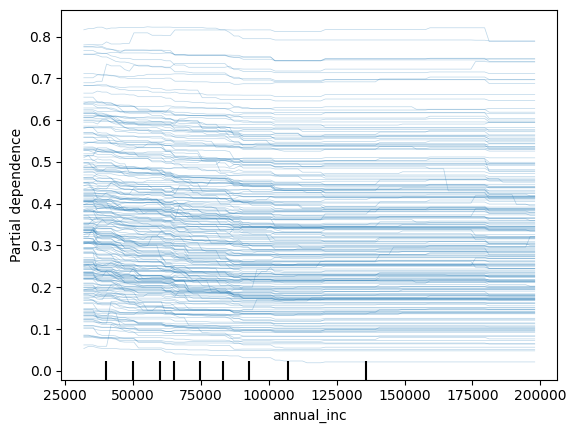

In [15]:
PartialDependenceDisplay.from_estimator(full_pipeline, 
                                        X_train.sample(n_sample), 
                                        features=['annual_inc'],
                                        kind='individual')